# Parabolic partial differential equations

Preamble: Run the cells below to import the necessary Python packages

*This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.*

In [5]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Image

%matplotlib inline


### Two-spin Online Convex Optimization via convexification (correlation control)

Our optimization variables are discrete, and correspond to the spins of a 2-spin Ising model.

$$
\begin{align*}
    \mathcal{L} & = - \sum_{i=1}^N \sum_{j=1}^N J_{ij} s_i s_j \\
    \mathcal{L} & = - J_{12} s_1 s_2
\end{align*}
$$

We can globally minimize the loss simply by *combinatorial optimization*. We try all $2 \times 2 = 4$ possible values of the spins, and pick the one that minimizes the loss. However, while this is tractable for the two spin case, it is expensive (problem size scales in $N$ and likely non-convex. What if we instead wanted to pose this as an online learning problem suitable for iterative optimization? 

We need to define a surrogate loss that is convex and differentiable, and that we can optimize. For this case, we can use correlation:
$$
  \hat{\mathcal{L}} = s_1 s_2
$$

### Establishing bounds on the surrogate loss

At each round indexed by $t$, we propose a spin configuration $s_{1t}$, $s_{2t}$ we compute a surrogate loss $\hat{\mathcal{L}}$. We want to establish bounds on the surrogate loss, assuming that we made the worst possible choice for $s_{1t}$, $s_{2t}$.

$$
\begin{align*}
  \hat{\mathcal{L}} & = s_{1t} s_{2t} \\
  \hat{\mathcal{L}} & = s_{1t} s_{2t}
\end{align*}
$$


In [1]:
import numpy as np

def sample_spins_with_correlation(c, rng):
    """
    Given target correlation c in [-1,1], sample (s1,s2) in {±1}^2 with E[s1*s2]=c.
    """
    assert -1.0 <= c <= 1.0
    s1 = rng.choice([-1, 1])
    if rng.random() < (1 + c) / 2:
        s2 = s1
    else:
        s2 = -s1
    return s1, s2

def run_2spin_ogd(T=200, eta=None, j_seq=None, adversary="adaptive", seed=0):
    """
    Online gradient descent on the convex surrogate c_t ∈ [-1,1] for two spins.
    Loss per round: ℓ_t = - j_t * (s1_t*s2_t).
    Update on expected loss: c_{t+1} = Proj_{[-1,1]}(c_t + η * j_t).

    adversary:
      - "adaptive": chooses j_t = -sign(c_t) (worst for the current c_t), with tie broken uniformly
      - "given":    uses provided j_seq (length T), values in [-1,1]
      - "random":   j_t ~ Unif({-1, +1})
    """
    rng = np.random.default_rng(seed)
    if eta is None:
        eta = 2.0 / np.sqrt(T)  # OGD step ~ D/(G*sqrt(T)) with D=2, G≤1
    c = 0.0  # start at 0 correlation
    c_hist = []
    j_hist = []
    loss_realized = []
    loss_expected = []

    for t in range(T):
        # Adversary picks j_t after seeing c_t
        if adversary == "adaptive":
            s = np.sign(c)
            if s == 0:
                j_t = rng.choice([-1.0, 1.0])
            else:
                j_t = -float(s)  # linear loss -j*c is maximized by j = -sign(c)
        elif adversary == "given":
            if j_seq is None or len(j_seq) != T:
                raise ValueError("Provide j_seq of length T for adversary='given'.")
            j_t = float(j_seq[t])
        elif adversary == "random":
            j_t = rng.choice([-1.0, 1.0])
        else:
            raise ValueError("adversary must be in {'adaptive','given','random'}")
        j_hist.append(j_t)

        # Play discrete spins realizing correlation c
        s1, s2 = sample_spins_with_correlation(c, rng)
        prod = s1 * s2

        # Losses
        loss_t_real = - j_t * prod
        loss_t_exp  = - j_t * c
        loss_realized.append(loss_t_real)
        loss_expected.append(loss_t_exp)

        # OGD update on the convex surrogate (expected loss)
        c = np.clip(c + eta * j_t, -1.0, 1.0)
        c_hist.append(c)

    # Best fixed comparator over c in {±1} (equivalently, best fixed spin product)
    S = float(np.sum(j_hist))
    c_star = 1.0 if S < 0 else -1.0 if S > 0 else 1.0  # minimizes -S*c
    comp_expected = - c_star * S

    out = {
        "c_hist": np.array(c_hist),
        "j_hist": np.array(j_hist),
        "loss_realized": np.array(loss_realized),
        "loss_expected": np.array(loss_expected),
        "cum_loss_realized": float(np.sum(loss_realized)),
        "cum_loss_expected": float(np.sum(loss_expected)),
        "cum_loss_comp_expected": float(comp_expected),
        "regret_expected": float(np.sum(loss_expected) - comp_expected),
        "params": {"T": T, "eta": eta, "adversary": adversary, "seed": seed}
    }
    return out


res2 = run_2spin_ogd(T=200, adversary="adaptive", seed=0)
print("2-spin: cum expected loss =", res2["cum_loss_expected"],
        " comparator exp. loss =", res2["cum_loss_comp_expected"],
        " regret_exp =", res2["regret_expected"])


2-spin: cum expected loss = 14.142135623730947  comparator exp. loss = -0.0  regret_exp = 14.142135623730947


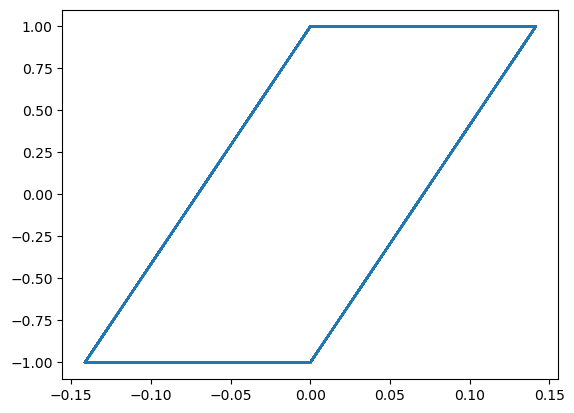

In [8]:
plt.plot(res2["c_hist"], res2["j_hist"])

In [9]:



# ============================================================
# 2) n-spin Ising with adversarial J_t, convex relaxation
#    (elliptope surrogate + Gaussian sign rounding)
#    NOTE: uses an approximate projection to the elliptope.
# ============================================================

def project_psd_with_unit_diag(C, eps=1e-10):
    """
    Approximate projection onto {C ⪰ 0, diag(C)=1}.
    Steps: symmetrize → set diag to 1 → PSD projection (clip neg eigvals) → reset diag to 1.
    This is not the exact elliptope projection (which is an SDP), but works well in practice.
    """
    C = 0.5 * (C + C.T)
    np.fill_diagonal(C, 1.0)
    # PSD projection
    w, V = np.linalg.eigh(C)
    w_clipped = np.clip(w, a_min=0.0, a_max=None)
    C_psd = (V * w_clipped) @ V.T
    C_psd = 0.5 * (C_psd + C_psd.T)
    # Enforce unit diagonal again (light renormalization)
    d = np.sqrt(np.maximum(np.diag(C_psd), eps))
    D_inv = np.diag(1.0 / d)
    C_norm = D_inv @ C_psd @ D_inv
    C_norm = 0.5 * (C_norm + C_norm.T)
    np.fill_diagonal(C_norm, 1.0)
    return C_norm

def gaussian_sign_rounding(C, rng):
    """
    Sample s ∈ {±1}^n via Gaussian sign rounding with covariance C.
    """
    n = C.shape[0]
    # Ensure strictly PD covariance for sampling
    jitter = 1e-8
    G = rng.multivariate_normal(mean=np.zeros(n), cov=C + jitter * np.eye(n))
    s = np.sign(G)
    s[s == 0] = 1
    return s.astype(int)

def adversary_against_spins(s):
    """
    Worst-case (entrywise-bounded) J_t for current spin s:
      J_ij = - s_i s_j for i ≠ j,  J_ii = 0.
    This maximizes loss -s^T J s subject to |J_ij| ≤ 1 and zero diagonal.
    """
    n = len(s)
    J = -np.outer(s, s)
    np.fill_diagonal(J, 0.0)
    return J

def run_nspin_online_relaxation(n=20, T=200, eta=None, J_seq=None, adversary="adaptive", seed=1):
    """
    Online linear optimization over the elliptope surrogate C_t, with Gaussian sign rounding to play spins.
    Loss per round: ℓ_t(s_t) = - s_t^T J_t s_t. Surrogate loss: L_t(C_t) = -⟨J_t, C_t⟩.

    Update: C_{t+1} ≈ Proj_{elliptope}( C_t + η * J_t )
    (gradient of L_t wrt C is -J_t; gradient DEScent step is C - η*(-J_t) = C + η J_t)

    adversary:
      - "adaptive": picks J_t = adversary_against_spins(s_t)
      - "given":    uses provided list of J_t (len T), symmetric with zero diagonal
      - "random":   i.i.d. J_t with entries in {-1, +1} off-diagonal and 0 on diagonal
    """
    rng = np.random.default_rng(seed)
    if eta is None:
        eta = 1.0 / np.sqrt(T)  # heuristic O(1/sqrt(T)) step
    C = np.eye(n)
    C_hist = []
    loss_realized = []
    loss_surrogate = []
    Js = []

    for t in range(T):
        # Play spins via rounding of current correlation C
        s = gaussian_sign_rounding(C, rng)

        # Adversary chooses J_t
        if adversary == "adaptive":
            J_t = adversary_against_spins(s)
        elif adversary == "given":
            if J_seq is None or len(J_seq) != T:
                raise ValueError("Provide J_seq (len T, symmetric, zero diagonal) for adversary='given'.")
            J_t = 0.5 * (J_seq[t] + J_seq[t].T)
            np.fill_diagonal(J_t, 0.0)
        elif adversary == "random":
            J_t = rng.choice([-1.0, 1.0], size=(n, n))
            J_t = 0.5 * (J_t + J_t.T)
            np.fill_diagonal(J_t, 0.0)
        else:
            raise ValueError("adversary must be in {'adaptive','given','random'}")
        Js.append(J_t)

        # Realized discrete loss
        loss_t = - float(s.T @ J_t @ s)
        loss_realized.append(loss_t)

        # Surrogate (expected) loss under C_t: -⟨J_t, C_t⟩
        loss_sur = - float(np.sum(J_t * C))
        loss_surrogate.append(loss_sur)

        # Online update on the surrogate
        C = C + eta * J_t
        C = project_psd_with_unit_diag(C)  # approximate projection
        C_hist.append(C.copy())

    # Comparator (best fixed spin in hindsight) for reporting:
    # NP-hard to compute exactly; we report the surrogate comparator instead.
    comp_surrogate = -float(np.sum(np.sum(Js, axis=0) * np.eye(n)))  # = 0 since diag=0; kept for clarity
    # Better: best fixed C in the surrogate is not trivial; we omit exact value and report totals.

    out = {
        "C_hist": C_hist,
        "loss_realized": np.array(loss_realized),
        "loss_surrogate": np.array(loss_surrogate),
        "cum_loss_realized": float(np.sum(loss_realized)),
        "cum_loss_surrogate": float(np.sum(loss_surrogate)),
        "params": {"n": n, "T": T, "eta": eta, "adversary": adversary, "seed": seed}
    }
    return out




# Example 2: n-spin relaxation with adaptive adversary
resN = run_nspin_online_relaxation(n=20, T=200, adversary="adaptive", seed=1)
print("n-spin: cum realized loss =", resN["cum_loss_realized"],
        " cum surrogate loss =", resN["cum_loss_surrogate"])

n-spin: cum realized loss = 76000.0  cum surrogate loss = 886.0047399131901


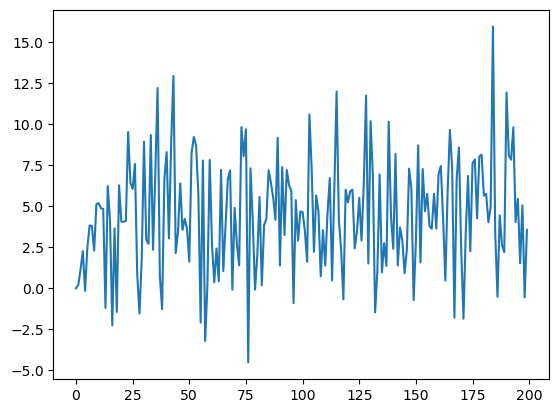

In [12]:
plt.plot(resN["loss_surrogate"])